In [1]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

In [2]:
def load_scws(rid):
    print("loading "+rid+"...")
    df1 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_scw_envs_df.csv")
    df2 = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/"+rid+"_non_scw_envs_df.csv")
    
    df1["cluster_new"] = df1.cluster.map({1:2,2:1,0:0})
    df1 = df1.set_index(pd.DatetimeIndex(df1.dt_utc))
    df1["month"] = df1.index.month
    df1["hour"] = df1.index.hour
    df1["year"] = df1.index.year
    df1["aspect_ratio"] = df1.major_axis_length / df1.minor_axis_length    
    
    df2["cluster_new"] = df2.cluster.map({1:2,2:1,0:0})
    df2 = df2.set_index(pd.DatetimeIndex(df2.dt_utc))
    df2["month"] = df2.index.month
    df2["hour"] = df2.index.hour
    df2["year"] = df2.index.year    
    df2["aspect_ratio"] = df2.major_axis_length / df2.minor_axis_length     
    
    df1["rid"] = rid
    df2["rid"] = rid
    
    return df1, df2

In [3]:
melb_scw, melb_null = load_scws("2")
bris_scw, bris_null = load_scws("66")
namoi_scw, namoi_null = load_scws("69")
perth_scw, perth_null = load_scws("70")
syd_scw, syd_null = load_scws("71")

loading 2...
loading 66...
loading 69...
loading 70...
loading 71...


209 65 124


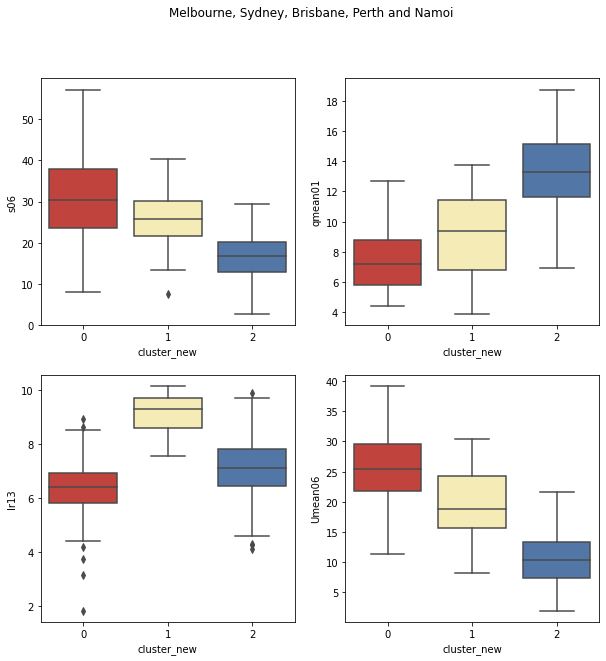

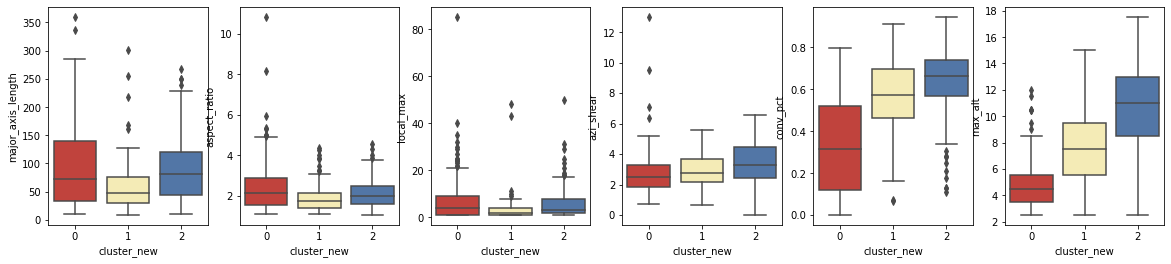

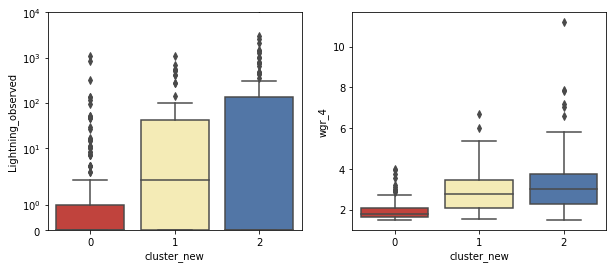

In [7]:
def plot_boxplot_stats(data, title):
    
    print( (data.cluster_new==0).sum(), (data.cluster_new==1).sum(), (data.cluster_new==2).sum())
    
    p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    
    plt.figure(figsize=[10,10])
    ax=plt.subplot(2,2,1)
    sns.boxplot(data=data, x="cluster_new", y="s06", palette=p)
    ax=plt.subplot(2,2,2)
    sns.boxplot(data=data, x="cluster_new", y="qmean01", palette=p)
    ax=plt.subplot(2,2,3)
    sns.boxplot(data=data, x="cluster_new", y="lr13", palette=p)
    ax=plt.subplot(2,2,4)
    sns.boxplot(data=data, x="cluster_new", y="Umean06", palette=p)
    plt.suptitle(title)
    
    plt.figure(figsize=[20,4])
    data["aspect_ratio"] = data["major_axis_length"] / data["minor_axis_length"]
    plt.subplot(1,6,1)
    sns.boxplot(data=data, x="cluster_new", y="major_axis_length", palette=p)
    plt.subplot(1,6,2)
    sns.boxplot(data=data, x="cluster_new", y="aspect_ratio", palette=p)
    plt.subplot(1,6,3)
    sns.boxplot(data=data, x="cluster_new", y="local_max", palette=p)
    plt.subplot(1,6,4)
    sns.boxplot(data=data, x="cluster_new", y="azi_shear", palette=p)
    plt.subplot(1,6,5)
    sns.boxplot(data=data, x="cluster_new", y="conv_pct", palette=p)
    plt.subplot(1,6,6)
    sns.boxplot(data=data, x="cluster_new", y="max_alt", palette=p)

    plt.figure(figsize=[10,4])
    plt.subplot(1,2,1)
    sns.boxplot(data=data, x="cluster_new", y="Lightning_observed", palette=p)
    plt.yscale("symlog")
    plt.ylim([0,10000])
    
    plt.subplot(1,2,2)
    sns.boxplot(data=data, x="cluster_new", y="wgr_4", palette=p)
                       
plot_boxplot_stats(pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0), "Melbourne, Sydney, Brisbane, Perth and Namoi")
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_boxplot.jpeg",dpi=1000,bbox_inches="tight")

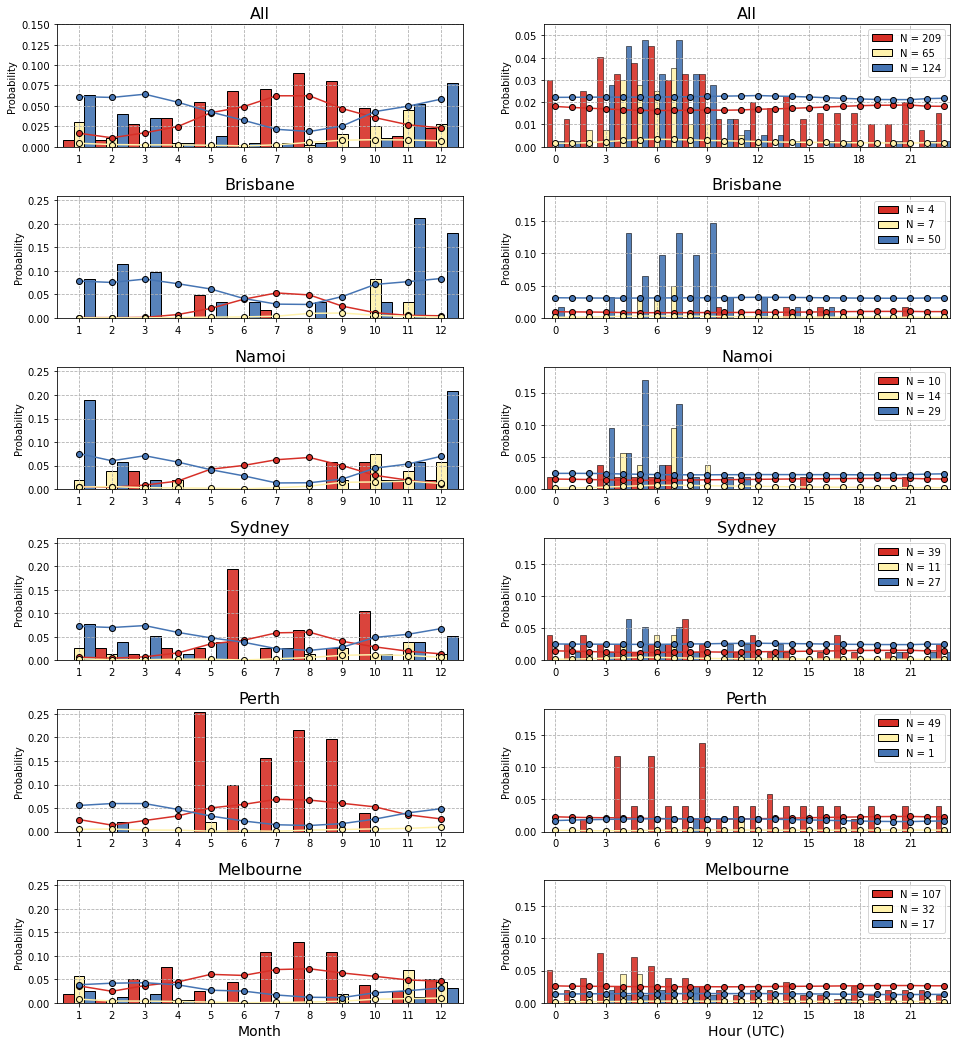

In [4]:
def create_legend(ax,p,labels):
    
    #create legend
    handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in p]
    plt.legend(handles, labels)

def plot_hists(data, title, ax1, ax2, ymax1, ymax2, kde=False, plot_total_counts=True, null_data=None):
    
    p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    
    sns.histplot(x="month",data=data,discrete=True,hue="cluster_new",multiple="dodge",palette=p, ax=ax1, legend=False, stat="probability", kde=kde, alpha=0.9,
                line_kws={"lw":3})
    ax1.set_title(title,size=16)
    ax1.grid(ls="--")
    ax1.set_ylim([0,ymax1])
    ax1.set_xticks(np.arange(1,13))
    ax1.set_xlim([0.33,12.66])
    ax1.set_xlabel("")
    create_legend(ax1, p, ["N = "+str((data.cluster_new==i).sum()) for i in np.arange(3)])
    
    if plot_total_counts:
        counts = null_data[["month","cluster_new"]].groupby(["cluster_new","month"]).agg("size")
        counts = counts / null_data.shape[0]
        ax1.plot(counts.loc[0],color=p[0],marker="o",mec="k")
        ax1.plot(counts.loc[1],color=p[1],marker="o",mec="k")
        ax1.plot(counts.loc[2],color=p[2],marker="o",mec="k")
    
    sns.histplot(x="hour",data=data,discrete=True,hue="cluster_new",multiple="dodge",palette=p, ax=ax2, legend=False, stat="probability", kde=kde, alpha=0.9,
                line_kws={"lw":3})
    ax2.set_title(title,size=16)
    ax2.grid(ls="--")
    ax2.set_ylim([0,ymax2])    
    ax2.set_xlabel("")
    ax2.set_xticks(np.arange(0,24,3))
    ax2.set_xlim([-0.66,23.33])
    create_legend(ax1, p, ["N = "+str((data.cluster_new==i).sum()) for i in np.arange(3)])
    
    if plot_total_counts:
        counts = null_data[["hour","cluster_new"]].groupby(["cluster_new","hour"]).agg("size")
        counts = counts / null_data.shape[0]
        ax2.plot(counts.loc[0],color=p[0],marker="o",mec="k")
        ax2.plot(counts.loc[1],color=p[1],marker="o",mec="k")
        ax2.plot(counts.loc[2],color=p[2],marker="o",mec="k")    

plt.figure(figsize=[16,18])

rows=6; cols=2

ax1 = plt.subplot(rows,cols,1); ax2 = plt.subplot(rows,cols,2)
plot_hists(pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0), "All", ax1, ax2, 0.15, 0.055, kde=False,
          null_data=pd.concat([melb_null[["cluster_new","hour","month"]], syd_null[["cluster_new","hour","month"]], bris_null[["cluster_new","hour","month"]], 
                               perth_null[["cluster_new","hour","month"]], namoi_null[["cluster_new","hour","month"]],
                                melb_scw[["cluster_new","hour","month"]], syd_scw[["cluster_new","hour","month"]], bris_scw[["cluster_new","hour","month"]], 
                               perth_scw[["cluster_new","hour","month"]], namoi_scw[["cluster_new","hour","month"]]],                              
                              axis=0))

ax1 = plt.subplot(rows,cols,3); ax2 = plt.subplot(rows,cols,4)
plot_hists(bris_scw, "Brisbane", ax1, ax2, 0.26, .19, null_data=pd.concat([bris_null[["cluster_new","hour","month"]],bris_scw[["cluster_new","hour","month"]]]))

ax1 = plt.subplot(rows,cols,5); ax2 = plt.subplot(rows,cols,6)
plot_hists(namoi_scw, "Namoi", ax1, ax2, 0.26, .19, null_data=pd.concat([namoi_null[["cluster_new","hour","month"]],namoi_scw[["cluster_new","hour","month"]]]))

ax1 = plt.subplot(rows,cols,7); ax2 = plt.subplot(rows,cols,8)
plot_hists(syd_scw, "Sydney", ax1, ax2, 0.26, .19, null_data=pd.concat([syd_null[["cluster_new","hour","month"]],syd_scw[["cluster_new","hour","month"]]]))

ax1 = plt.subplot(rows,cols,9); ax2 = plt.subplot(rows,cols,10)
plot_hists(perth_scw, "Perth", ax1, ax2, 0.26, .19, null_data=pd.concat([perth_null[["cluster_new","hour","month"]],perth_scw[["cluster_new","hour","month"]]]))

ax1 = plt.subplot(rows,cols,11); ax2 = plt.subplot(rows,cols,12)
plot_hists(melb_scw, "Melbourne", ax1, ax2, 0.26, .19, null_data=pd.concat([melb_null[["cluster_new","hour","month"]],melb_scw[["cluster_new","hour","month"]]]))

ax1.set_xlabel("Month", size=14); ax2.set_xlabel("Hour (UTC)", size=14)
plt.subplots_adjust(hspace=0.4)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_temporal_hist.jpeg",dpi=1000,bbox_inches="tight")

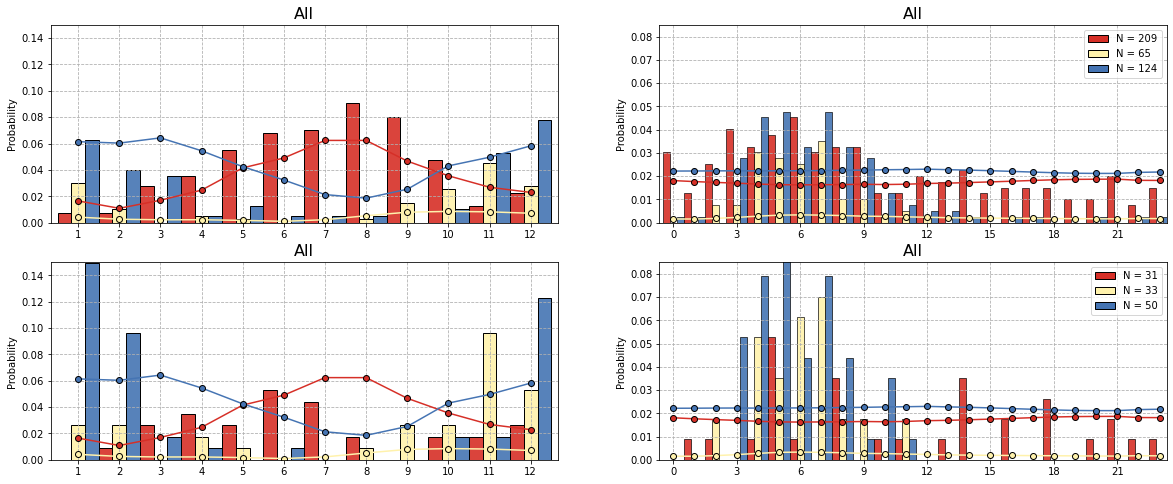

In [35]:
plt.figure(figsize=[20,8])

plot_hists(pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0), "All", plt.subplot(2,2,1), plt.subplot(2,2,2), 0.15, 0.085, kde=False,
          null_data=pd.concat([melb_null[["cluster_new","hour","month"]], syd_null[["cluster_new","hour","month"]], bris_null[["cluster_new","hour","month"]], 
                               perth_null[["cluster_new","hour","month"]], namoi_null[["cluster_new","hour","month"]],
                                melb_scw[["cluster_new","hour","month"]], syd_scw[["cluster_new","hour","month"]], bris_scw[["cluster_new","hour","month"]], 
                               perth_scw[["cluster_new","hour","month"]], namoi_scw[["cluster_new","hour","month"]]],                              
                              axis=0))

plot_hists(pd.concat([melb_scw.query("(Lightning_observed>=2) & (year>2015)"), syd_scw.query("(Lightning_observed>=2) & (year>2015)"), bris_scw.query("(Lightning_observed>=2) & (year>2015)"), 
                      perth_scw.query("(Lightning_observed>=2) & (year>2015)"), namoi_scw.query("(Lightning_observed>=2) & (year>2015)")]
                     , axis=0), "All", plt.subplot(2,2,3), plt.subplot(2,2,4), 0.15, 0.085, kde=False,
          null_data=pd.concat([melb_null[["cluster_new","hour","month"]], syd_null[["cluster_new","hour","month"]], bris_null[["cluster_new","hour","month"]], 
                               perth_null[["cluster_new","hour","month"]], namoi_null[["cluster_new","hour","month"]],
                                melb_scw[["cluster_new","hour","month"]], syd_scw[["cluster_new","hour","month"]], bris_scw[["cluster_new","hour","month"]], 
                               perth_scw[["cluster_new","hour","month"]], namoi_scw[["cluster_new","hour","month"]]],                              
                              axis=0))

dt_utc
2008-04-02 02:49:00    2008
2008-04-02 06:01:00    2008
2008-09-15 02:53:00    2008
2008-11-13 08:28:00    2008
2008-12-12 17:53:00    2008
                       ... 
2020-05-19 14:27:00    2020
2020-08-27 07:49:00    2020
2020-11-15 12:44:00    2020
2020-12-06 03:36:00    2020
2020-12-27 06:55:00    2020
Name: year, Length: 156, dtype: int64

In [9]:
data=pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0).dropna(subset=["azi_shear"])

#Linear
data.loc[(data.aspect_ratio>=3) & (data.major_axis_length>=100),"class2"] = "Linear"
#Non-linear
data.loc[(data.aspect_ratio<3) & (data.major_axis_length>=100),"class2"] = "Non-linear"
#Cellular
data.loc[(data.local_max == 1),"class2"] = "Cellular"
#Macroburst
data.loc[(data.local_max>=2) & (data.major_axis_length<100),"class2"] = "Cell cluster"
#Supercell
data.loc[(data.azi_shear>4.5) & ((data.aspect_ratio<3) | (data.major_axis_length<100)),"class2"] = "Supercellular"
#Shallow
data.loc[(data.max_alt<8) & (data.conv_pct<.4),"class2"] = "Shallow"

data=data.sort_values("class2")

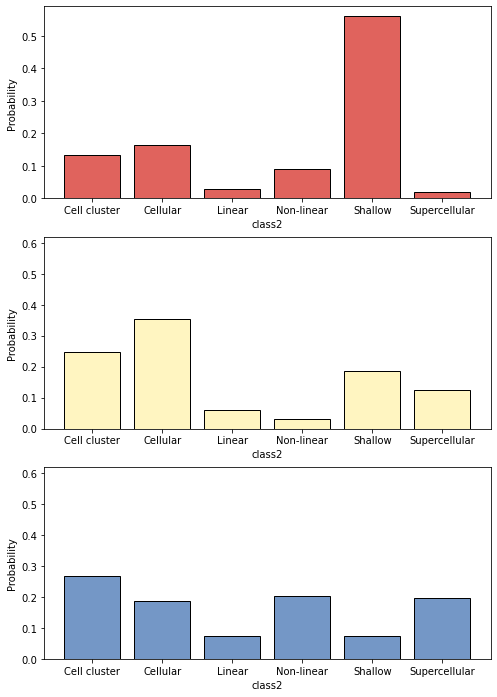

In [10]:
plt.figure(figsize=[8,12])
p = [plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]

plt.subplot(3,1,1)
sns.histplot(x="class2",data=data.query("cluster_new==0"),discrete=True,multiple="dodge",palette=p,shrink=0.8, stat="probability",color=p[0])
plt.subplot(3,1,2)
sns.histplot(x="class2",data=data.query("cluster_new==1"),discrete=True,multiple="dodge",palette=p,shrink=0.8, stat="probability",color=p[1])
plt.ylim([0,0.62])
plt.subplot(3,1,3)
sns.histplot(x="class2",data=data.query("cluster_new==2"),discrete=True,multiple="dodge",palette=p,shrink=0.8, stat="probability",color=p[2])
plt.ylim([0,0.62])

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_cluster_modes.jpeg",dpi=1000,bbox_inches="tight")

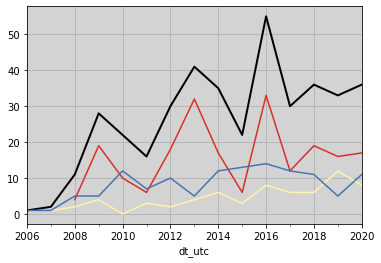

In [13]:
pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0).resample("1Y").nunique().group_id.plot(color="k",lw=2)
pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0).query("cluster==0").resample("1Y").nunique().group_id.plot(color=p[0])
pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0).query("cluster==2").resample("1Y").nunique().group_id.plot(color=p[1])
pd.concat([melb_scw, syd_scw, bris_scw, perth_scw, namoi_scw], axis=0).query("cluster==1").resample("1Y").nunique().group_id.plot(color=p[2])
plt.gca().set_facecolor("lightgray")
plt.gca().grid()

In [76]:
def plot_box(ax,v,df,yscale,y1,y2):
    p = [(0.5,0.5,0.5)]+[plt.get_cmap("RdYlBu")(i) for i in [0.1,0.46,0.9]]
    sns.boxplot(data=df,x="cluster_new",y=v,whis=1.5,palette=p)    
    plt.ylabel(v,size=14)
    ax.set_yscale(yscale)
    ax.tick_params(labelsize=12)
    plt.ylim([y1,y2])
    ax.grid(axis="y")

In [109]:
data_null=pd.concat([melb_null, syd_null, bris_null, perth_null, namoi_null], axis=0).dropna(subset=["azi_shear"])
data_null=data_null[data_null.in10km==1].drop_duplicates(["year","month","rid","uid10"])
data_null["cluster_new"] = -1
data = pd.concat([data,data_null],axis=0)
data["wgr_sherb"] = data["gust"] / data["speed"]

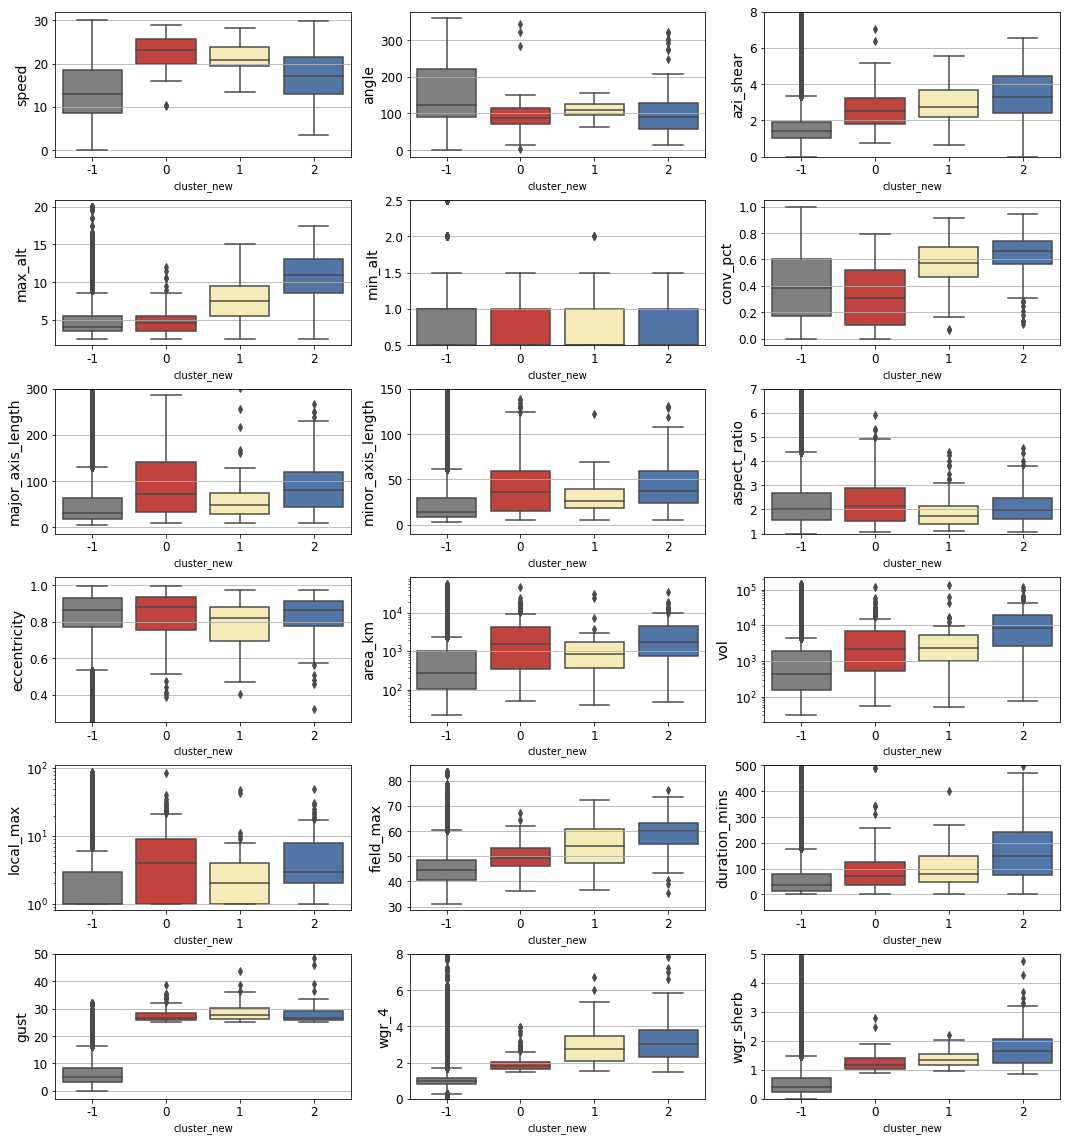

In [113]:
var = ["speed","angle","azi_shear","max_alt","min_alt","conv_pct","major_axis_length","minor_axis_length",
       "aspect_ratio","eccentricity","area_km","vol","local_max","field_max","duration_mins","gust","wgr_4","wgr_sherb"]
log_vars = ["area_km","local_max","vol"]
symlog_vars = []
yscales = dict.fromkeys(var,"linear"); 
for v in log_vars:
    yscales[v]="log" 
for v in symlog_vars:
    yscales[v]="symlog"     
y1 = dict.fromkeys(var,None)
y2 = dict.fromkeys(var,None); 
y1["azi_shear"] = 0; y1["min_alt"] = 0.5; y1["aspect_ratio"] = 1; y1["eccentricity"] = 0.25; y1["wgr_4"]=0; y1["wgr_sherb"]=0
y2["speed"]=32; y2["min_alt"] = 2.5; y2["azi_shear"] = 8; y2["major_axis_length"]=300; y2["minor_axis_length"]=150; y2["aspect_ratio"]=7; 
y2["duration_mins"]=500; y2["gust"]=50; y2["wgr_4"]=8; y2["wgr_sherb"]=5

plt.figure(figsize=[18,20])
for i in np.arange(len(var)):
    ax=plt.subplot(6,3,i+1)
    if var[i] in ["speed","angle","wgr_sherb"]:
        plot_box(ax,var[i],data.query("(speed_rnge<4) & (speed<30)"),yscales[var[i]],y1[var[i]],y2[var[i]])
    else:
        plot_box(ax,var[i],data,yscales[var[i]],y1[var[i]],y2[var[i]])
        
plt.subplots_adjust(hspace=0.3)
plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/scws_storm_hist_cluster.jpeg",dpi=1000,bbox_inches="tight")

In [107]:
data.sort_values("wgr_4",ascending=False).Lightning_observed

dt_utc
2013-01-26 21:25:00    2.0
2013-01-26 21:25:00    2.0
2015-07-20 11:13:00    0.0
2015-07-20 11:13:00    0.0
2014-03-26 15:00:00    0.0
                      ... 
2020-06-22 17:49:00    0.0
2020-06-22 19:43:00    0.0
2011-05-30 05:03:00    0.0
2016-09-24 16:11:00    0.0
2019-06-02 14:01:00    0.0
Name: Lightning_observed, Length: 244639, dtype: float64

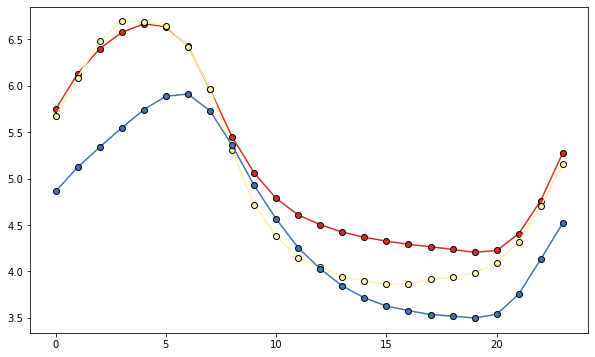

In [138]:
v="gust"
temp=pd.concat([melb_scw[[v,"hour","cluster_new"]], syd_scw[[v,"hour","cluster_new"]], bris_scw[[v,"hour","cluster_new"]], 
                perth_scw[[v,"hour","cluster_new"]], namoi_scw[[v,"hour","cluster_new"]],
               melb_null[[v,"hour","cluster_new"]], syd_null[[v,"hour","cluster_new"]], bris_null[[v,"hour","cluster_new"]], 
                perth_null[[v,"hour","cluster_new"]], namoi_null[[v,"hour","cluster_new"]]], axis=0).groupby(["cluster_new","hour"]).mean()

plt.figure(figsize=[10,6])
plt.plot(temp.loc[0],color=p[0],marker="o",mec="k")
plt.plot(temp.loc[1],color=p[1],marker="o",mec="k")
plt.plot(temp.loc[2],color=p[2],marker="o",mec="k")

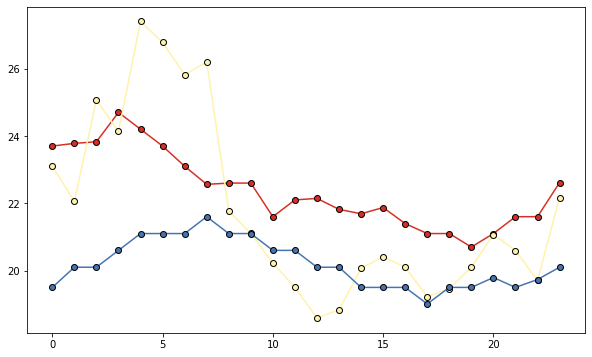

In [147]:
v="gust"
temp=pd.concat([melb_scw[[v,"hour","cluster_new"]], syd_scw[[v,"hour","cluster_new"]], bris_scw[[v,"hour","cluster_new"]], 
                perth_scw[[v,"hour","cluster_new"]], namoi_scw[[v,"hour","cluster_new"]],
               melb_null[[v,"hour","cluster_new"]], syd_null[[v,"hour","cluster_new"]], bris_null[[v,"hour","cluster_new"]], 
                perth_null[[v,"hour","cluster_new"]], namoi_null[[v,"hour","cluster_new"]]], axis=0).groupby(["cluster_new","hour"]).quantile(.9995)

plt.figure(figsize=[10,6])
plt.plot(temp.loc[0],color=p[0],marker="o",mec="k")
plt.plot(temp.loc[1],color=p[1],marker="o",mec="k")
plt.plot(temp.loc[2],color=p[2],marker="o",mec="k")

In [165]:
temp=pd.concat([melb_scw[[v,"hour","cluster_new"]], syd_scw[[v,"hour","cluster_new"]], bris_scw[[v,"hour","cluster_new"]], 
                perth_scw[[v,"hour","cluster_new"]], namoi_scw[[v,"hour","cluster_new"]],
               melb_null[[v,"hour","cluster_new"]], syd_null[[v,"hour","cluster_new"]], bris_null[[v,"hour","cluster_new"]], 
                perth_null[[v,"hour","cluster_new"]], namoi_null[[v,"hour","cluster_new"]]], axis=0)
#sns.histplot(data=temp,x="gust",hue="cluster_new",palette=p,discrete=True,multiple="dodge",)
a=temp.query("cluster_new==0").gust
b=temp.query("cluster_new==1").gust
c=temp.query("cluster_new==2").gust

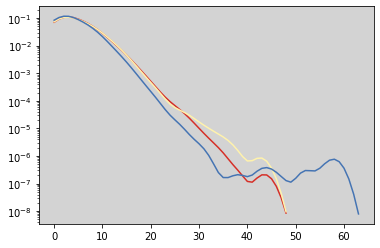

In [196]:
# sns.displot(data=melb_null,x="gust",hue="cluster_new",kind="kde")
from scipy.stats import gaussian_kde as kde

sig=0.5
plt.plot(kde(a.values,sig).pdf(np.arange(1,50)),color=p[0])
plt.plot(kde(b.values,sig).pdf(np.arange(1,50)),color=p[1])
plt.plot(kde(c.values,sig).pdf(np.arange(1,65)),color=p[2])
plt.yscale("log")

plt.gca().set_facecolor('lightgray')

In [200]:
melb_scw["2020-01-31"]

/jobfs/38255774.gadi-pbs/ipykernel_2291272/3314223227.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  melb_scw["2020-01-31"]


,Unnamed: 0,dt_utc,group_id,scan,uid10,dist0km,dist10km,dist20km,in10km,stn_id,...,era5_lon,Lightning_observed,cluster,bdsd,rolling4,wgr_4,cluster_new,month,hour,aspect_ratio
dt_utc,,,,,,,,,,,,,,,,,,,,,
2020-01-31 03:47:00,1106621,2020-01-31 03:47:00,20200131034228/1904,7067.0,1904.0,0.471,0.471,0.471,1.0,90035,...,143.75,1.0,2,0.996484,10.560166,3.134420,1,1,3,1.488491
2020-01-31 05:04:00,1108614,2020-01-31 05:04:00,20200131050031/1942,7080.0,1942.0,0.295,0.295,0.295,1.0,86220,...,145.00,1.0,2,0.999666,8.179668,3.288642,1,1,5,1.210475
2020-01-31 07:22:00,1112223,2020-01-31 07:22:00,20200131071828/1954,7103.0,1954.0,6.034,6.034,6.034,1.0,90035,...,143.75,1.0,2,0.999592,8.290041,4.053056,1,1,7,1.180798


In [216]:
melb_scw.Lightning_observed.sort_values().iloc[-10:]

dt_utc
2018-07-17 05:04:00      47.0
2013-09-30 13:58:00      47.0
2018-12-01 16:36:00      52.0
2017-11-23 03:34:00      55.0
2018-11-20 05:19:00      56.0
2016-12-29 03:58:00     221.0
2010-08-24 08:19:00     313.0
2016-11-21 05:16:00     542.0
2017-12-19 08:28:00    1064.0
2017-12-19 05:15:00    1064.0
Name: Lightning_observed, dtype: float64